In [280]:
import os
import copy

import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed, mark_boundaries
from skimage.exposure import histogram
from skimage.morphology import remove_small_objects, binary_closing, skeletonize
from skimage.transform import resize, rotate

In [3]:
!tree 

.
├── oil_analysis.ipynb
├── storage_tanks.jpg
└── tank_1.jpg

0 directories, 3 files


## Images 

Some example images of oil refinery sites where taken from [here](https://blog.spaceknow.com/cushing/). The examples are DigitalGlobe imagery.

In [304]:
PX_TO_M = 0.3 # assuming digital globe 30cm sensor

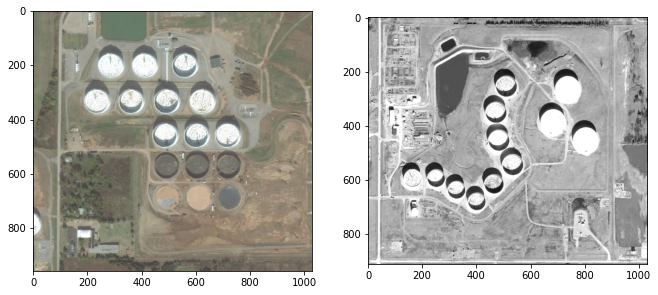

In [93]:
tank = plt.imread('storage_tanks.jpg')
tank1 = plt.imread('storage_tanks_2.jpg')
f = plt.figure(figsize=(11, 11))
ax = f.add_subplot(121)
ax.imshow(tank, cmap='gray')
ax1 = f.add_subplot(122)
ax1.imshow(tank1, cmap='gray')

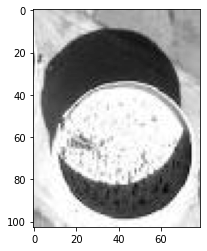

In [272]:
img = cv2.imread('tank_3.jpg', 0)
plt.imshow(img, cmap='gray')

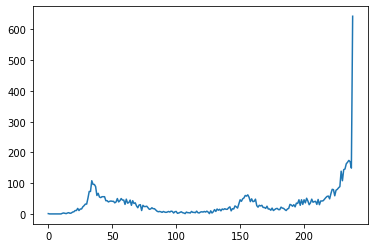

In [273]:
hist, hist_centers = histogram(img)
plt.plot(hist)

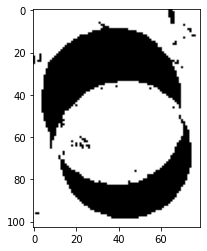

In [274]:
img = np.uint8(cv2.normalize(img.copy(), None, 0, 255, cv2.NORM_MINMAX))
ret, img = cv2.threshold(img, 255, 255, cv2.THRESH_OTSU)
plt.imshow(img, cmap='gray')

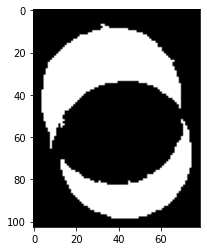

In [275]:
img = np.invert(img)
shadow = img > 0
clean = remove_small_objects(shadow, min_size=300)
clean = remove_small_objects(clean, min_size=300)
clean = np.uint8(clean)
plt.imshow(clean, cmap='gray')

In [284]:
from scipy.ndimage.interpolation import rotate

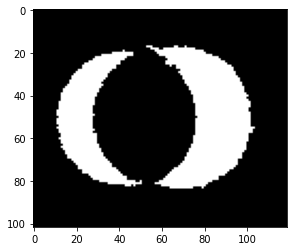

In [285]:
img_rot = copy.copy(clean)
img_rot = rotate(img_rot, -104, reshape=True)
# img_rot = np.uint8(img_rot)
plt.imshow(img_rot, cmap='gray')

(102, 119)

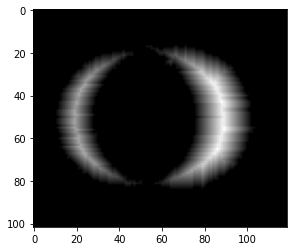

In [278]:
img_trans = img_rot.copy()
dists = cv2.distanceTransform(img_trans, cv2.DIST_L1, 5)

plt.imshow(dists, cmap='gray')

dists.shape

In [ ]:
'''
If detection bounding box is centred around tank+shadow, can assume each shadow exists on one half of the box. 

Internal shadow: only consider widths with an x_pos < 0.5 * img.shape[1]
External shadow: only consider widths.x_pos >= 0.5 *  img.shape[1]
''' 

In [287]:
inside_shadow_widths = []
inside_positions = []
outside_shadow_widths = []
outside_positions = []

for i, row in enumerate(dists):
    
    row_widths = [j for j in row]
    
    in_widths = row_widths[:(int(0.5*len(row_widths)))]
    out_widths = row_widths[(int(0.5*len(row_widths))):]
    
    inside_shadow_widths.append(max(in_widths)*2)
    outside_shadow_widths.append(max(out_widths)*2)
    
    xpos_in = in_widths.index(max(in_widths))
    xpos_out = out_widths.index(max(out_widths))
    
    inside_positions.append((i, xpos_in))
    outside_positions.append((i, xpos_out+int(0.5*len(row_widths))))

In [288]:
inside_shadow = [(w, pos) for w, pos in zip(inside_shadow_widths, inside_positions)]
outside_shadow = [(w, pos) for w, pos in zip(outside_shadow_widths, outside_positions)]

In [294]:
print(outside_shadow)

[(0.0, (0, 59)), (0.0, (1, 59)), (0.0, (2, 59)), (0.0, (3, 59)), (0.0, (4, 59)), (0.0, (5, 59)), (0.0, (6, 59)), (0.0, (7, 59)), (0.0, (8, 59)), (0.0, (9, 59)), (0.0, (10, 59)), (0.0, (11, 59)), (0.0, (12, 59)), (0.0, (13, 59)), (0.0, (14, 59)), (0.0, (15, 59)), (0.0, (16, 59)), (2.0, (17, 66)), (4.0, (18, 66)), (6.0, (19, 66)), (8.0, (20, 66)), (10.0, (21, 66)), (12.0, (22, 71)), (14.0, (23, 71)), (14.0, (24, 71)), (16.0, (25, 73)), (18.0, (26, 75)), (18.0, (27, 76)), (20.0, (28, 78)), (22.0, (29, 78)), (22.0, (30, 79)), (22.0, (31, 80)), (24.0, (32, 81)), (26.0, (33, 83)), (26.0, (34, 83)), (26.0, (35, 84)), (26.0, (36, 85)), (26.0, (37, 85)), (26.0, (38, 86)), (26.0, (39, 86)), (26.0, (40, 87)), (26.0, (41, 87)), (26.0, (42, 87)), (28.0, (43, 88)), (26.0, (44, 88)), (26.0, (45, 88)), (26.0, (46, 88)), (26.0, (47, 88)), (26.0, (48, 88)), (26.0, (49, 88)), (26.0, (50, 89)), (26.0, (51, 88)), (26.0, (52, 88)), (26.0, (53, 88)), (26.0, (54, 88)), (28.0, (55, 89)), (28.0, (56, 89)), (26.

Text(0.5, 1.0, 'Outside Shadow Length Profile')

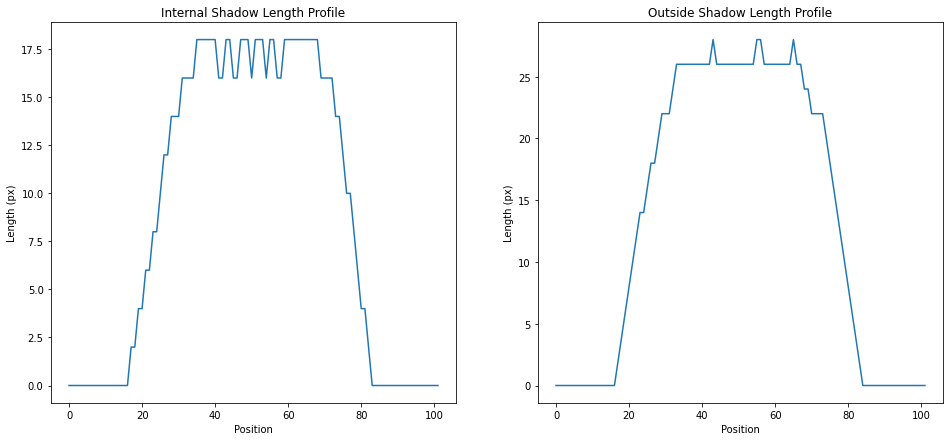

In [291]:
f = plt.figure(figsize=(16,7))
f.add_subplot(121)
plt.plot(range(dists.shape[0]), inside_shadow_widths)
plt.ylabel('Length (px)')
plt.xlabel('Position')
plt.title('Internal Shadow Length Profile')
f.add_subplot(122)
plt.plot(range(dists.shape[0]), outside_shadow_widths)
plt.ylabel('Length (px)')
plt.xlabel('Position')
plt.title('Outside Shadow Length Profile')

In [295]:
l1=(18.0, (51, 19))
l2=(28.0, (55, 89))

In [ ]:
lengths = [l1, l2]

img = cv2.imread('tank_3.jpg')
img_rot = rotate(img, -104, reshape=True, mode='reflect')

# cv2.line(img, (x1,y1), (x2,y2))

for l in lengths:
    cv2.line(img_rot, (l[1][1] - (int(0.5*l[0])) + 1, l[1][0]), (l[1][1] + (int(0.5*l[0])) - 1, l[1][0]), (255,0,0), 1)
    plt.annotate(s='{}m'.format(round(l[0]*PX_TO_M)), xy=(l[1][1], l[1][0]), xytext=(l[1][1], l[1][0]), color='w', fontsize=5)
    
plt.figure(figsize=(6,6))
plt.imshow(img_rot, cmap='gray')